In [1]:
%pylab inline 
import os
import cv2
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['figure.figsize'] = (14, 12)

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plot_images(images, row=1, im_prep=None, titles=None, cmap=None):
    add_col = 1 if (len(images) % row) else 0
    col = (len(images) // row) + add_col
    fig, axes = subplots(row,col, subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    if im_prep is None:
        im_prep = lambda x: x

    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        img = im_prep(images[i])
        if (len(img.shape) < 3) and cmap is None:
            cmap='gray'
        ax.imshow(img, cmap=cmap)
        if titles is not None:
            ax.set_title(titles[i])
    show()

In [14]:
class BirdEyeTransform():
    def __init__(self):
        self.dist = np.array([[-0.24688507, -0.02373154, -0.00109831,  0.00035107, -0.00259869]])
        self.mtx = np.array([
            [  1.15777818e+03,   0.00000000e+00,   6.67113857e+02],
            [  0.00000000e+00,   1.15282217e+03,   3.86124583e+02],
            [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
        self.camera_M = np.array([
            [ -4.09514513e-01,  -1.54251784e+00,   9.09522880e+02],
            [ -3.55271368e-15,  -1.95774942e+00,   8.94691487e+02],
            [ -3.57786717e-18,  -2.38211439e-03,   1.00000000e+00]])

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def warp_camera(self, img, inv=False):
        if len(img.shape)==3:
            img_size = img.shape[-2::-1]
        else:
            img_size = img.shape[::-1]
        flags = cv2.INTER_LINEAR + cv2.WARP_FILL_OUTLIERS
        if inv:
            flags += cv2.WARP_INVERSE_MAP
        return cv2.warpPerspective(img, self.camera_M, img_size, flags=flags)
    
    def transform(self, img, inv=False):
        """
        returns undistorted and warped img
        """
        undist = self.undistort(img)

        warp = self.warp_camera(undist, inv)
        return warp
        

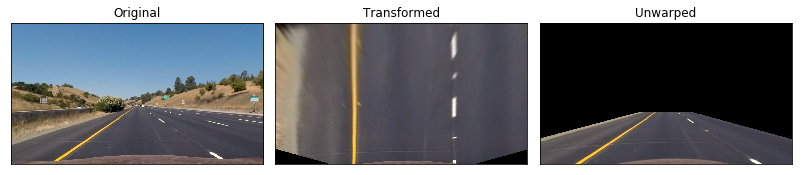

In [15]:
n = BirdEyeTransform()
camera_img = cv2.imread('test_images/straight_lines1.jpg')
warp = n.transform(undist)

plot_images((undist, warp, n.transform(warp, True)), titles=('Original', 'Transformed', 'Unwarped'), im_prep=bgr2rgb)

In [41]:
class ImageSobelBinarizer():
    def __init__(self):
        pass
    
    def binarize(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gradx  = self.abs_sobel_threshold(gray, 'x', 5, thresh=(30, 100))
        grady = self.abs_sobel_threshold(gray, 'y', 15, thresh=(20, 100))
        mg_thresh = self.mag_thresheld(gray, sobel_kernel=5, mag_thresh=(15, 70))
        dir_thresh = self.dir_threshold(gray, sobel_kernel=15, thresh=(-0.1, .8))
        
        combined = np.zeros(img.shape[:2])
        combined[((gradx == 1) & (grady != 1)) | ((mg_thresh == 1) & (dir_thresh == 1))] = 1
        return combined

    def abs_sobel_threshold(self, gray, orient='x', sobel_kernel=3, thresh=(20, 100)):
        # sobel threshold
        dx = 1 if orient == 'x' else 0
        dy = 1 if orient != 'x' else 0
        sobel = cv2.Sobel(gray, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        thresh_min = thresh[0]
        thresh_max = thresh[1]
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return sxbinary

    def mag_thresheld(self, gray, sobel_kernel=3, mag_thresh=(20, 100)):
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output

    def dir_threshold(self, gray, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output
        

In [112]:
class ImageHlsBinarizer():
    def __init__(self):
        pass
    
    def binarize(self, img):
        return self.ls_threshold(img)
    
    def ls_threshold(self, img, l_thresh_min=40, s_thresh_min=100):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        l = hls[:,:,1]
        s = hls[:,:,2]
        ret = np.zeros_like(s, dtype=np.ubyte)
        ret[(l>l_thresh_min) & (s>s_thresh_min)] = 1
        return ret        

In [204]:
class ImageSobelHlsBinarizer():
    def __init__(self):
        self.birdEyeTransform = BirdEyeTransform()
        self.sobelBinarizer = ImageSobelBinarizer()
        self.hlsBinarizer = ImageHlsBinarizer()
    
    def binarize(self, frame):
        img = self.birdEyeTransform.transform(frame)
        sobel = self.sobelBinarizer.binarize(img)
        hls_bin = self.hlsBinarizer.binarize(img)
        binary = np.zeros(img.shape[:2])
        binary[(hls_bin == 1) | (sobel == 1)] = 255
        #binary = region_of_interest(binary)
        return binary
    
    def undistort(self, frame):
        return self.birdEyeTransform.undistort(frame)
    
    def unwarp(self ,img):
        return self.birdEyeTransform.warp_camera(img, True)

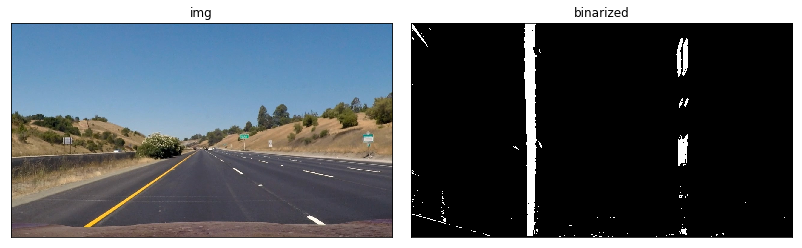

In [223]:
combined = ImageSobelHlsBinarizer().binarize(camera_img)
plot_images((bgr2rgb(camera_img), combined), titles=('img', 'binarized'))

In [205]:
class Line():
    def __init__(self, margin=100):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.margin = margin
        self.base = 0
        self.fitx = None
        self.minpix = 50
        self.nwindows = 9
        self.ploty = None
        
    def _process_window(self, win_y_low, win_y_high, nonzero):
        # Identify window boundaries in x and y (and right and left)
        win_x_low = self.base - self.margin
        win_x_high = self.base + self.margin
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_inds) > self.minpix:
            self.base = np.int(np.mean(nonzerox[good_inds]))
        #print("process_window len(inds)", len(good_inds))
        return good_inds
    
    def _slide_window(self, frame_bin):
        nonzero = frame_bin.nonzero()
        window_height = frame_bin.shape[0]//self.nwindows
        lane_inds = []
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = frame_bin.shape[0] - (window+1)*window_height
            win_y_high = frame_bin.shape[0] - window*window_height
            inds = self._process_window(win_y_low, win_y_high, nonzero)
            lane_inds.append(inds)
        lane_inds = np.concatenate(lane_inds)
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]
        fit = np.polyfit(y, x, 2) 
        #print(fit)
        return fit
    
    def _plot(self, frame):
        line_window1 = np.array([np.transpose(np.vstack([self.fitx-self.margin, self.ploty]))])
        line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+self.margin, self.ploty])))])
        line_pts = np.hstack((line_window1, line_window2))

        
            
    def update(self, frame_bin, base=None, ploty=None, found=True):
        self.detected=found
        if ploty is not None:
            self.ploty = ploty
        if found:
            if base is not None:
                self.base = base
            fit = self._slide_window(frame_bin)
            #print('fit is ', fit)
            self.fitx = fit[0]*self.ploty**2 + fit[1]*self.ploty + fit[2]
        

In [232]:
class LinesSearch():
    def __init__(self, image_binarizer, windows_count=10):
        self.left_line = Line()
        self.right_line = Line()
        self.windows_count = windows_count
        self.frame = None
        self.image_binarizer=image_binarizer
        self.ploty = None
       
    def _is_line_detected(self):
        return self.left_line.detected and self.right_line.detected
    
    def _get_ploty(self):
        if self.ploty is None:
            self.ploty = np.linspace(0, self.frame.shape[0], self.frame.shape[0], endpoint=False)
        return self.ploty
    
    def _detect_lines(self):
        half_height = self.binary.shape[0]//2
        half_frame = self.binary[half_height:,:]
        self.histogram = np.sum(half_frame, axis=0)
        l1_base = np.argmax(self.histogram)
        margin = self.left_line.margin
        # TODO: could be out of shape:
        l1 = [l1_base - margin, l1_base + margin]
        l2_hist = np.concatenate((self.histogram[:l1[0]], self.histogram[l1[1]:]))
        l2_base = np.argmax(l2_hist) + (2 * margin)
        left_base = min(l1_base, l2_base)
        right_base = max(l1_base, l2_base)
        self.left_line.update(self.binary, left_base, self._get_ploty())
        self.right_line.update(self.binary, right_base, self._get_ploty())
    
    def plot(self):
        left_fitx = self.left_line.fitx
        right_fitx = self.right_line.fitx
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        color_warp = np.zeros(self.frame.shape, dtype=np.ubyte)
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        unidst = self.image_binarizer.undistort(self.frame)
        unwarp = self.image_binarizer.unwarp(color_warp)
        ret = cv2.addWeighted(self.frame, 1, unwarp, 0.3, 0)
        imshow(bgr2rgb(ret))

    def _binarize(self, frame):
        return self.image_binarizer.binarize(frame)
        
    def search(self, frame):
        self.frame = frame
        self.binary = self._binarize(frame)
        if not self._is_line_detected():
            print("detecting")
            self._detect_lines()
        else:
            print('guessing')
            self.left_line.update(self.binary)
            self.right_line.update(self.binary)
            

ls = LinesSearch(ImageSobelHlsBinarizer())
ls.search(img)

detecting


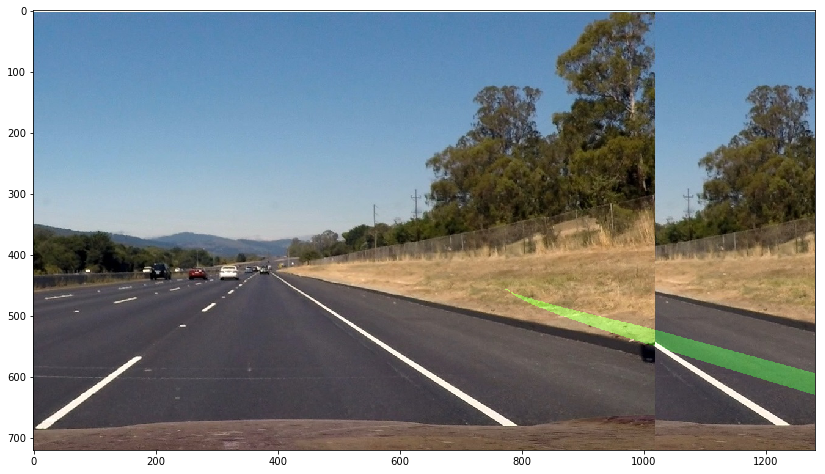

In [233]:
ls.plot()

In [234]:
ls.search(camera_img)

guessing


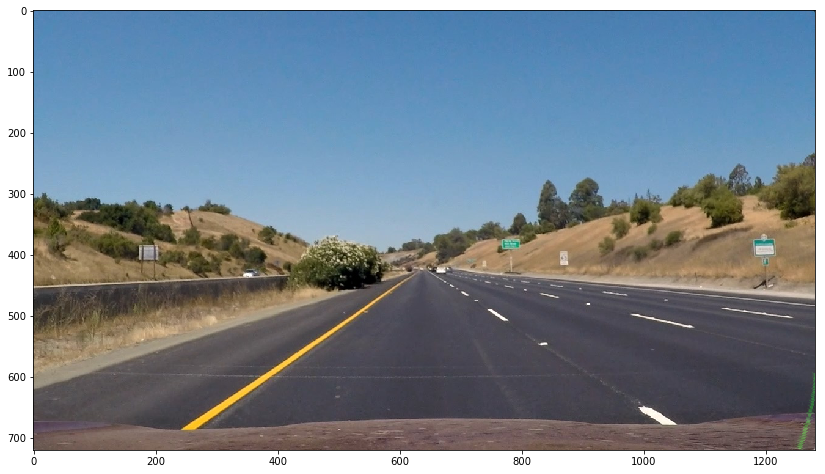

In [235]:
ls.plot()